In [11]:
import numpy as np
from distance import *
import pandas as pd
import matplotlib.pyplot as pl

- Data: $X_i \equiv (\mu_i, z_i)$

- Cosmological parameters: ${\Omega} = {\Omega_{\Lambda}, \Omega_{m}, \Omega_{k}}$

- Likelihood: $$P( \vec X| \Omega_m, \Omega_{\Lambda}, \Omega_k) \propto \exp \left( -\frac{1}{2}\Delta \vec \mu \cdot C^{-1} \cdot \Delta \vec \mu\right)$$

where
$\Delta  \mu_{i} = \mu_{i} -  \mu_{model}(z_i; \Omega)$

In [8]:
#loading data
data=pd.read_csv('lcparam_DS17f.txt',delimiter=' ')
cov_data = np.array(pd.read_csv('sys_DS17f.txt'))

# create numpy version data
red_shift_data = (data['zcmb']).to_numpy()
apparent_magnitude_data = (data['mb']).to_numpy() 
apparent_magnitude_standard_errors = (data['dmb']).to_numpy()
cov_matrix = cov_data.reshape(40, 40)



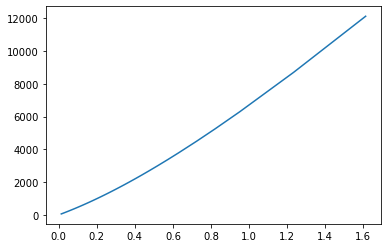

In [9]:
d_L = luminosity_dist(red_shift_data,.286,.714,69.6,1E2,"s")

pl.plot(red_shift_data,d_L)

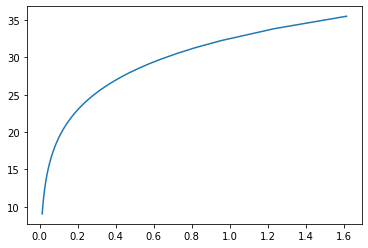

In [10]:
mu_model = distance_modulus(red_shift_data,.286,.714,69.6,1E2)
pl.plot(red_shift_data,mu_model)

(-inf, 0, -inf)

In [29]:
math.inf*1


inf